# SCRIPT 2
Edit raw data and compute velocity components.

Steps:
1. ds_raw: Load an individual raw drifter dataset with GPS, temperature and other variables on non-uniform t.
    Create tgrid_hourly from the original time data.
2. ds_qc: Flag + remove bad GPS data
    - Where the GPS has dropped out (= mode),
    - Where it is outside the North Atlantic box (na_lonlim, na_latlim)
    - Where the velocity is unrealistic (larger than 3 m/s)
    - Where the time series of longitude and latitude (compared to a one-dimensional five-point median filter) is more than five standard deviations from the five-point median)
     Compute the u and v velocities on the QC GPS fixes
4. ds_lowess: Smooth the GPS (and velocities) using the Lowess filter*.  *Shane's code online doesn't seem to smooth velo with a Lowess
5. ds_hourly: Hourly interpolate the resultant ds_lowess back onto the tgrid_hourly.  Interpolate the other parameters from ds_raw onto the hourly grid (temperature, etc)
    > 'linear' for continuous variables
    > 'nearest neighbour' for discrete ones

6. save as netcdf file

Last modified: 5 Sep 2021

In [1]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats
import time
from scipy.io import loadmat


%load_ext autoreload
%autoreload 2

# Local import
# > Make sure SIO_wrap dir is on the same path as this script.

from SIO_wrap import dir_tree, fnames
from SIO_wrap.lowess import LatLonLocalWess
from SIO_wrap import jlab_python as jlab
from SIO_wrap import drifter_qc as dqc

from setdir import *



/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


# User edits

In [2]:
# Path for the output data
data_dir = dir_tree.dir_out

#--------------
# Flag value - good=1, bad=4
good_flagval = 1
bad_gps_flagval = 4 
bad_vel_flagval = 3

# FLAG 1: Latitude values less than this threshold are flagged + removed?
#latbad_threshold = 0
# Use statistical mode instead

# FLAG 2: North Atlantic box; values outside this box are flagged + removed?
# Defined from -180 to 180 (lon) and -90 to 90 (lat)
na_lonlim = [-80, 30]
na_latlim = [40, 80]

#--------------
# Speed threshold; values outside [-3, 3] m/s are flagged + removed?
vel_threshold = 3 # in m/s

#--------------
# LOWESS params
poly_order = 1
bandwidth = 2

#------------
# Names of variables
latname = 'GPS_Latitude_deg'
lonname = 'GPS_Longitude_deg'
uvelname = 'uvel'
vvelname = 'vvel'

#--------------
# Time formats
tstamp_strf = '%Y%m%d'  # Filename timestamp
timcol_strf = '%Y-%m-%d %H:%M:%S'  # Convert text to datetime format 
url_strf = '%Y-%m-%d'
mtime_strf = '%Y-%m-%dT%H:%M:%S'


# Reference date for computing time in seconds
# Can use an earlier time reference if data start before 2000
ref_time = datetime.datetime(2000, 1, 1)

#--------------
# List of variable names split between float/int types based on whether the 
# variables are continuous or discrete, respectively.
# <!> If the names of variables change, update the lists by printing a list of 
# all the names from the raw datafile: list(xarrayDataset.keys())

integ_vars = ['Drogue_cnts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF', 
              'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries']

float_vars = [lonname, latname, 'SST_degC', 'time_seconds',
              'SLP_mB', 'Battery_volts', uvelname, vvelname]


In [3]:
# Process bathymetry data
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
mfile = 'labsea_66.44W_45.68N_5min'
input_bathy_file = cat_interim_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]

data_vars = {'depth': (['lat', 'lon'], bathy, 
                       {'units': 'm', 'long_name': 'water depth'})}

coords = {'lat': (['lat'], bathylat),
          'lon': (['lon'], bathylon)}

attrs = {'creation_date': datetime.datetime.now().strftime(tstamp_strf),
         'author' : 'efw',
         'email': 'eleanorfrajka@gmail.com'}

ds_bathy = xr.Dataset(data_vars=data_vars,
                      coords=coords,
                      attrs=attrs)

ds_bathy.to_netcdf(cat_proc_path(mfile+'.nc'),'w')

PermissionError: [Errno 13] Permission denied: b'/Users/eddifying/Python/drifters/01-data/03-processed/labsea_66.44W_45.68N_5min.nc'

# Step 1. Load raw data

Check the list of PIDs and decide which ones need to be updated.

In [3]:
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)


# Check whether a given Platform ID has been processed and is up-to-date
# If not, then add it to the update list
PID_to_update = []
counter = 0

# Extract a list with the names of existing raw data files.
for i in range(len(PID)):
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]

    # Extract a list with the names of existing raw data files.
    fname = 'pid'+str(PID1)+'.nc'
    existing_raw = glob.glob(cat_raw_path(fname))
    existing_int = glob.glob(cat_interim_path(fname))

    # Check whether any files exist in the intermediate directory for that PID
    if len(existing_int)*len(existing_raw):
        latest_raw = max(existing_raw, key=os.path.getctime)
        latest_int = max(existing_int, key=os.path.getctime)

        # Load the raw and interim data files
        ds_raw = xr.open_dataset(latest_raw)
        ds_int = xr.open_dataset(latest_int)
        
        # Check the end time
        maxtime_raw = pd.to_datetime(ds_raw.attrs["End Time"])
        maxtime_int = pd.to_datetime(ds_raw.attrs["End Time"])
        
        # Check if the latest raw file is at least 1 day longer than 
        # the latest interim file
        if not maxtime_raw==maxtime_int:
            dtime = maxtime_raw - maxtime_int
            print(dtime)
            counter += 1
            PID_to_update.append(PID1)
            maxtimestr_raw = ds_raw.attrs["End Time"]
            maxtimestr_int = ds_int.attrs["End Time"]
            print(str(counter)+'. pid('+pid1+') - Ended:'+maxtimestr_raw
              +', New end:'+maxtimestr_int)
    elif len(existing_int)==0:
        counter += 1
        PID_to_update.append(PID1)
        print(str(counter)+'. pid('+pid1+') - No interim file exists')

1. pid(300234068342820) - No interim file exists
2. pid(300234066517030) - No interim file exists
3. pid(300234068242470) - No interim file exists
4. pid(300234066516010) - No interim file exists
5. pid(300234068242990) - No interim file exists
6. pid(300234068242480) - No interim file exists
7. pid(300234066416690) - No interim file exists
8. pid(300234066516020) - No interim file exists
9. pid(300234068342840) - No interim file exists
10. pid(300234066517050) - No interim file exists
11. pid(300234066516030) - No interim file exists
12. pid(300234068343360) - No interim file exists
13. pid(300234066515010) - No interim file exists
14. pid(300234068345410) - No interim file exists
15. pid(300234068349510) - No interim file exists
16. pid(300234066516040) - No interim file exists
17. pid(300234068341840) - No interim file exists
18. pid(300234066516050) - No interim file exists
19. pid(300234068243540) - No interim file exists
20. pid(300234068343380) - No interim file exists
21. pid(3

In [4]:
# Load a raw file to process it
start_time = time.time()
donebefore=0
counter = 0
todaystr = datetime.datetime.now().strftime(url_strf)

#-----------------------------------------------------------------------
# Cycle through the PID's that need updating
#-----------------------------------------------------------------------
for i in range(len(PID_to_update)):
    counter += 1
    #-----------------------------------------------------------------------
    # Pick the PID
    pid1 = (PID_to_update[i]).astype('str')
    PID1 = PID_to_update[i]

    #-----------------------------------------------------------------------
    # Load the raw data
    fname = 'pid'+pid1+'.nc'
    raw_files = glob.glob(cat_raw_path(fname))
    latest_raw = max(raw_files, key=os.path.getctime)
    ds_raw = xr.open_dataset(latest_raw)

    print(str(counter)+'. '+fname+' - processing')

    #-----------------------------------------------------------------------
    # Remove variables we won't use here
    fields_to_remove = ['Battery_volts', 'GPS_HDOP', 'GPS_FixDelay',
                        'GPS_TTFF', 'GPS_NumSat', 'SBD_Transmit_Delay',
                        'SBD_Retries', 'SST_degC', 'SLP_mB']

    #-----------------------------------------------------------------------
    # Step 2: Flag bad values - location
    #-----------------------------------------------------------------------
    doneit, ds_qc, qc_attr_dict = dqc.drifter_flagbad(ds_raw, 
                                                      fields_to_remove, 
                                                      lonname, latname, 
                                                      good_flagval, ref_time,
                                                      bad_gps_flagval, 
                                                      na_latlim, na_lonlim,
                                                      uvelname, vvelname, 
                                                      vel_threshold,
                                                      bad_vel_flagval)


    if doneit:
        #----------------------------------------------------------------
        # Step 3: Filter with Lowess
        #----------------------------------------------------------------
        ds_lowess = dqc.drifter_filter(ds_qc, lonname, latname,
                                       poly_order, bandwidth)


        # Create the hourly time grid
        tgrid_hourly, tgrid_sec = dqc.create_hourly_grid(ds_raw["time"], 
                                                          ref_time)

        #----------------------------------------------------------------
        # Step 4: Interpolate hourly
        #----------------------------------------------------------------
        ds_hourly = dqc.drifter_hourly(ds_lowess, ds_qc, ds_raw, 
                                       tgrid_hourly, tgrid_sec,
                                       integ_vars, float_vars,
                                       lonname, latname,
                                       uvelname, vvelname,
                                      qc_attr_dict)

        #----------------------------------------------------------------
        # Update attributes about Dataset
        maxtime = tgrid_hourly.max()
        maxtimestr = pd.to_datetime(maxtime).strftime(mtime_strf)

        procstr = 'Flagged GPS out of LabSea, ran Lowess filter with ' \
                    f'poly_order({poly_order}) and bandwidth({bandwidth})'

        # Create a dictionary of attributes
        attr_dict = {"Platform_ID": PID1,
             "End Time": maxtimestr,
             "Date created": todaystr,
             "Processing": procstr,
            }

        ds_hourly = ds_hourly.assign_attrs(attr_dict)
        ds_hourly = ds_hourly.assign_attrs(qc_attr_dict)

        # ---------------------------------
        # Save data
        # ---------------------------------
        # Output filename (will be the same as raw, 
        # but in 01-data/02-intermediate/)
        data_fname = os.path.basename(latest_raw)
        data_fpath = cat_interim_path(data_fname)
        ds_hourly.to_netcdf(data_fpath)

        # How long did it take
        current_time = time.time()
        elapsed_time = current_time-start_time
        print('Done in '+str(int(elapsed_time))+' seconds')        

1. pid300234068342820.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 1200 for GPS dropouts, 163 for region, 0 for velo
Done in 27 seconds
2. pid300234066517030.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 558 for GPS dropouts, 0 for region, 0 for velo
Done in 88 seconds
3. pid300234068242470.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 0 for GPS dropouts, 44 for region, 0 for velo
Done in 92 seconds
4. pid300234066516010.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 325 for GPS dropouts, 0 for region, 0 for velo
Done in 147 seconds
5. pid300234068242990.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 163 for GPS dropouts, 0 for region, 0 for velo
Done in 171 seconds
6. pid300234068242480.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 314 for GPS dropouts, 0 for region, 0 for velo
Done in 186 seconds
7. pid300234066416690.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 109 for GPS

/Users/eddifying/Python/drifters/02-code/SIO_wrap/drifter_qc.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ds_qc.flag.values[lat_logical] = badflag
/Users/eddifying/Python/drifters/02-code/SIO_wrap/drifter_qc.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ds_qc.flag.values[lat_logical] = badflag


Flagged 0 for GPS dropouts, 66 for region, 0 for velo
Done in 2174 seconds
76. pid300234066510050.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 1019 for GPS dropouts, 0 for region, 0 for velo
Done in 2209 seconds
77. pid300234068245220.nc - processing
<class 'xarray.core.dataset.Dataset'>
Flagged 656 for GPS dropouts, 16 for region, 0 for velo
Done in 2263 seconds


NameError: name 'ds_lowess' is not defined

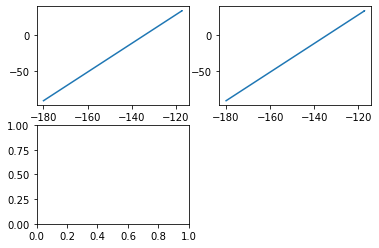

In [18]:
# Retrospectively fix the lon/lat problem
ax1 = plt.subplot(2,2,1)
plt.plot(ds_raw[lonname], ds_raw[latname])
ax2 = plt.subplot(2,2,2)
plt.plot(ds_qc[lonname], ds_qc[latname])
#ax2.title('QC')
ax3 = plt.subplot(2,2,3)
plt.plot(ds_lowess[lonname], ds_lowess[latname])
ax4 = plt.subplot(2,2,4)
plt.plot(ds_hourly[lonname], ds_hourly[latname])



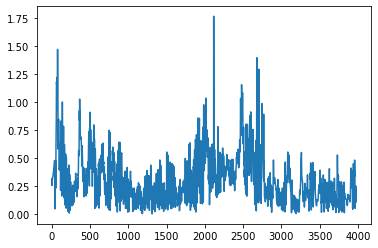

In [10]:
velmag = np.sqrt(np.square(ds_hourly.uvel) + np.square(ds_hourly.vvel))
plt.plot(velmag)


In [16]:
# Create a table summarising the data?
all_tstart= np.zeros(len(PID), dtype='datetime64[ns]')

#all_tend = np.ones(len(PID), dtype=datetime64[ns])

for i in range(len(PID)):
    # Get a single platform ID from the full list
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]


    fname = 'pid'+str(PID1)+'_*'
    hourly_files = glob.glob(cat_interim_path(fname))
    if len(hourly_files):
        hourly_files = sorted(hourly_files)
        # Find the most recent file (alphabetically, rather than by time)
        hourly_files = hourly_files[-1]

        ds_hourly = xr.open_dataset(hourly_files)

        total = ds_hourly.attrs["total_points_orig"]
        total_qc = ds_hourly.attrs["qc_points"]
        tstart = ds_hourly.time.min().values
        tend = ds_hourly.time.max().values
        
        all_tstart[i] = tstart
#        all_tend.append(tend)
    else:
        all_tstart[i] = np.datetime64("NaT")



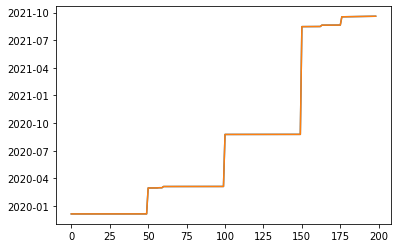

In [98]:
plt.plot(np.sort(all_tstart))
isort = np.argsort(all_tstart)

plt.plot(all_tstart[isort])

(array([50.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0., 23.]),
 array([18234.875     , 18247.95416667, 18261.03333333, 18274.1125    ,
        18287.19166667, 18300.27083333, 18313.35      , 18326.42916667,
        18339.50833333, 18352.5875    , 18365.66666667, 18378.74583333,
        18391.825     , 18404.90416667, 18417.98333333, 18431.0625    ,
        18444.14166667, 18457.22083333, 18470.3       , 18483.37916667,
        18496.45833333, 18509.5375    , 18522.61666667, 18535.69583333,
        18548.775     , 18561.85416667, 18574.93333333, 18588.0125    ,
        18601.09166667, 18614.17083333, 18627.25      , 18640.32916667,
        18653.40833333, 18666.4875    , 18679.56666667, 18692.64583333,
        18705.725     , 18718.80416667, 18731.88333333, 18744.9625  

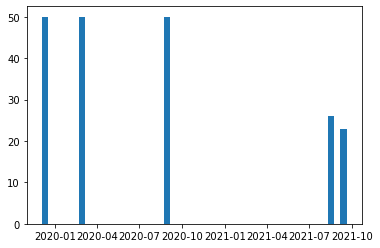

In [102]:
plt.hist(all_tstart, 50)

In [ ]:
iif 0:

    # ~ ~ print update ~ ~ 
    if len(existing_files) > 0:
        print("Existing raw data files: \n%s\n" % existing_files)
    else:
        sys.exit("No previous raw data files.\n")

    # ~ ~ filenaming convention ~ ~
    # If there are multiple files with raw data (i.e. non-updated datasets), select 
    # the latest one updated.
    # The file names are distinguished by the timestamp appended to the filename 
    # and has <tstamp_strftime> format (see 'user edits' section).
    # The data are cropped such that the last day is fully sampled (spans 0h-23h).
    # The timestamp in the filename is the latest downloaded fully sampled day.

    # Extract the timestamp part of the filename(s) in a list
    tstamp = [date for file in existing_files 
                for date in re.findall("(\d{8})", file)]

    # Convert to datetime and pick the most recent timestamp
    tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
    fname_timestamp = tstamp[tstamp_date.argmax()]

    # Load the raw file with the latest timestamp
    ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
    ds_fpath = os.path.join(data_dir, ds_fname)

    print("Opening file: %s\n" % ds_fpath)
    ds_raw = xr.open_dataset(ds_fpath)
